# pipeline 1

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

pyEDsoup = sc.read_h5ad("04_soup/pyED_correct_soupx.h5ad")
pyEDsoup.obs["Total"] = pyEDsoup.X.sum(axis=1)
print(pyEDsoup)

pyED = sc.read_h5ad("../data/pyED_correct.h5ad")
pyED
print(pyED)

cr = sc.read_10x_h5("../data/filtered_feature_bc_matrix.h5")
cr.var_names_make_unique()
print(cr)

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


AnnData object with n_obs × n_vars = 8202 × 22037
    obs: 'Total'
    uns: 'X_name'
AnnData object with n_obs × n_vars = 8202 × 22040
    obs: 'Total', 'PValue', 'Limited', 'LogProb', 'FDR'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'empty_drops'
AnnData object with n_obs × n_vars = 2701 × 22040
    var: 'gene_ids', 'feature_types', 'genome', 'interval'


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


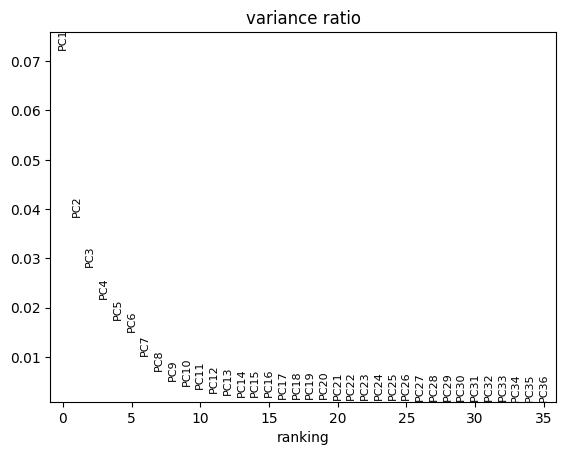

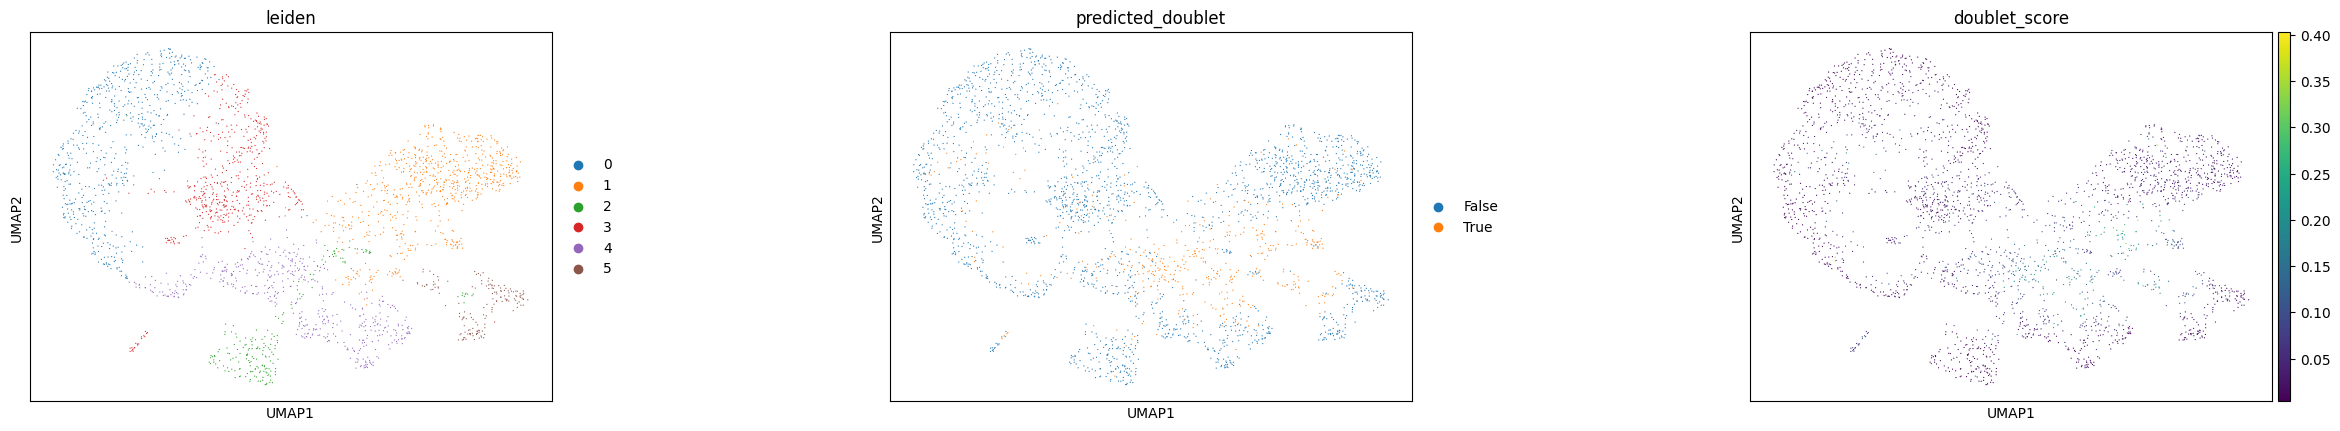

In [31]:
crc = cr.copy()
sc.pp.filter_genes(crc, min_counts=1)
sc.pp.scrublet(crc)
sc.pp.normalize_total(crc, target_sum=1e4)
sc.pp.log1p(crc)
sc.pp.pca(crc)
sc.pl.pca_variance_ratio(crc, n_pcs=35)
#sc.pl.pca(pyEDc,color=["PValue", "Total", "LogProb", "FDR"],dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],ncols=2,size=2,)
sc.pp.neighbors(crc)
sc.tl.umap(crc)
sc.tl.leiden(crc, flavor="igraph", n_iterations=-1, resolution=0.1)
sc.pl.umap(crc, color=["leiden", "predicted_doublet", "doublet_score"], wspace=0.5, size=3,)

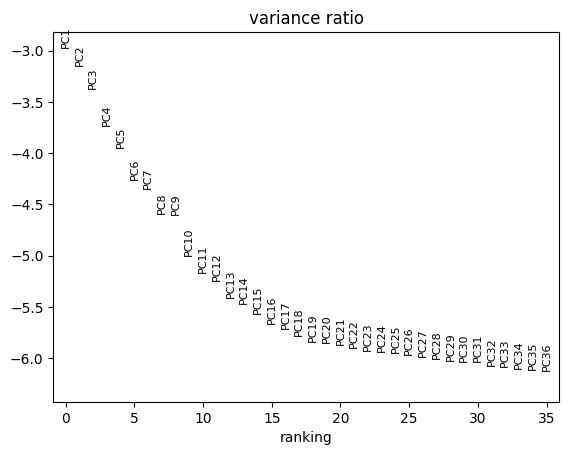

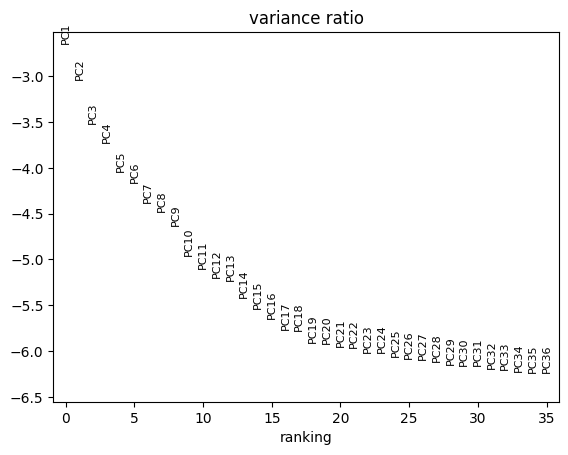

In [16]:
pyEDc = pyED.copy()
pyEDsoupc = pyEDsoup.copy()

sc.pp.filter_genes(pyEDc, min_counts=1)
sc.pp.scrublet(pyEDc)
sc.pp.normalize_total(pyEDc, target_sum=1e4)
sc.pp.log1p(pyEDc)
sc.pp.highly_variable_genes(pyEDc, n_top_genes=3000)
sc.pp.pca(pyEDc)
sc.pl.pca_variance_ratio(pyEDc, n_pcs=35, log=True)
#sc.pl.pca(pyEDc,color=["PValue", "Total", "LogProb", "FDR"],dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],ncols=2,size=2,)

sc.pp.normalize_total(pyEDsoupc, target_sum=1e4)
sc.pp.scrublet(pyEDsoupc)
sc.pp.log1p(pyEDsoupc)
sc.pp.highly_variable_genes(pyEDsoupc, n_top_genes=3000)
sc.pp.pca(pyEDsoupc)
sc.pl.pca_variance_ratio(pyEDsoupc, n_pcs=35, log=True)

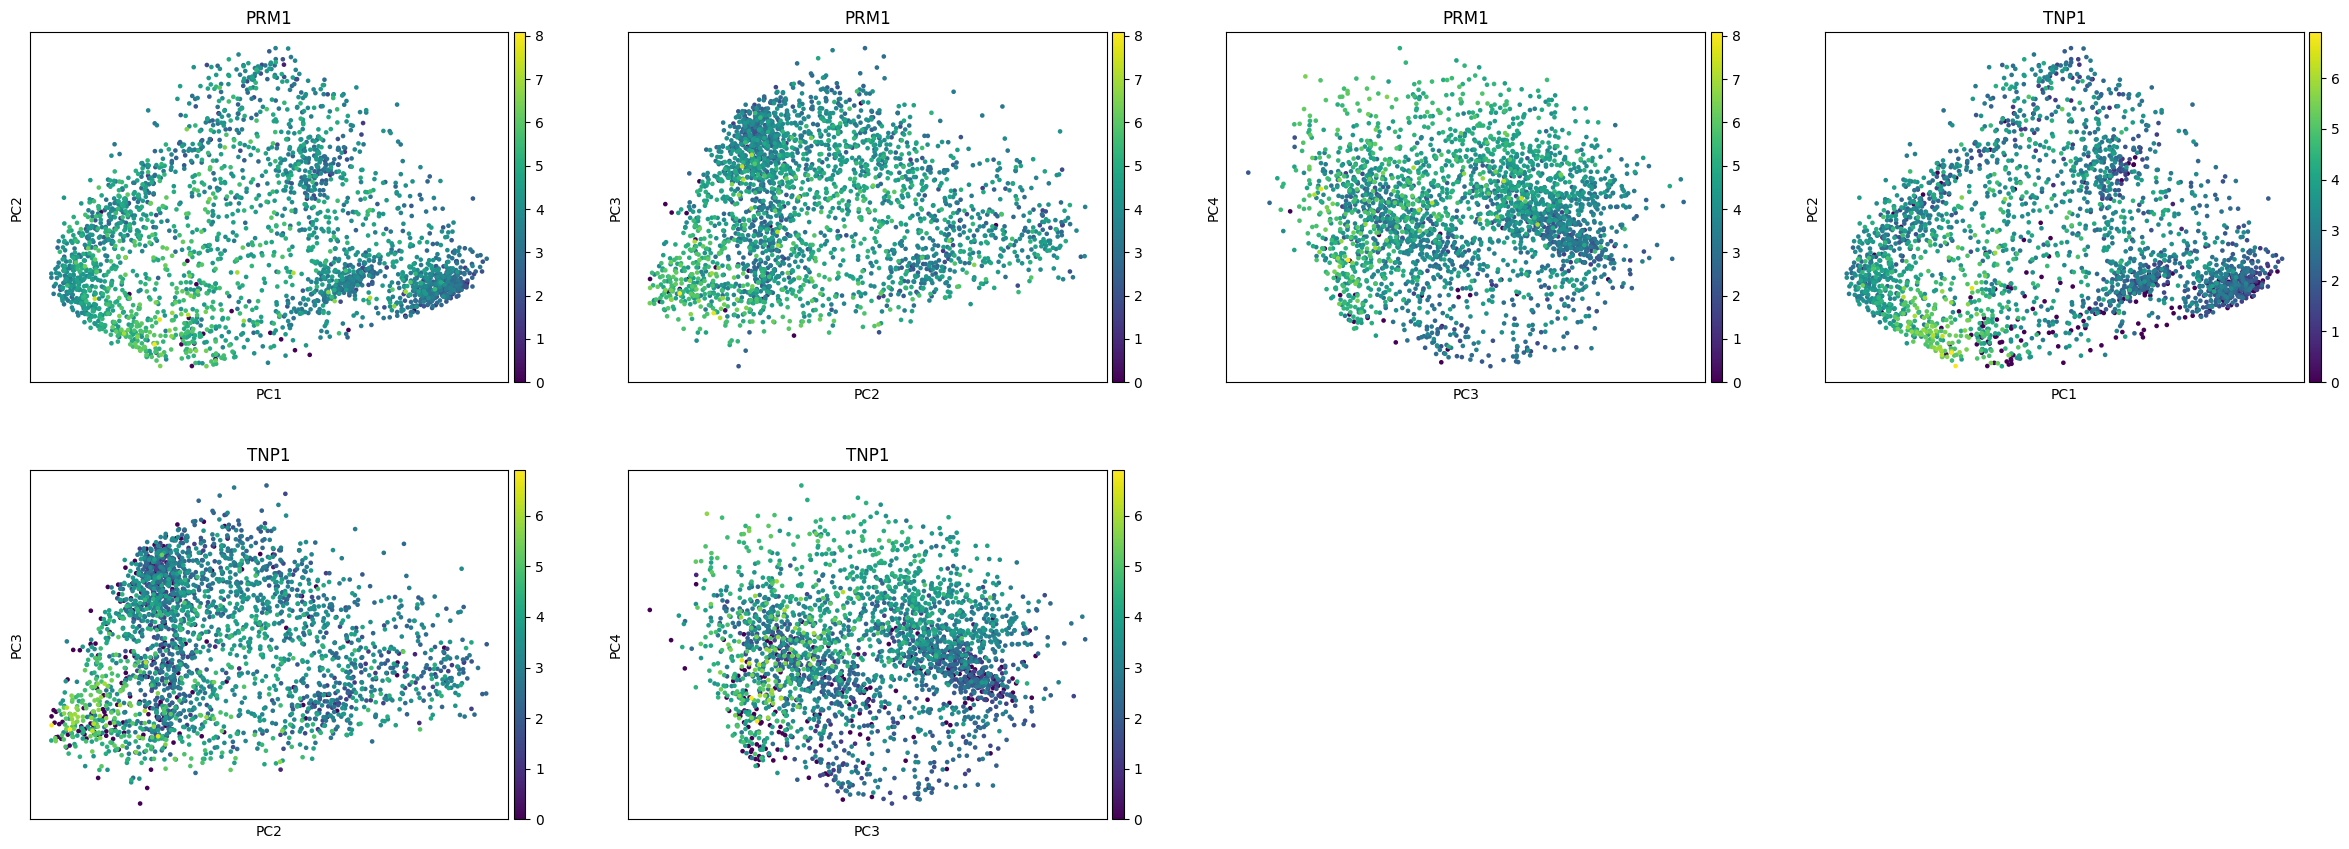

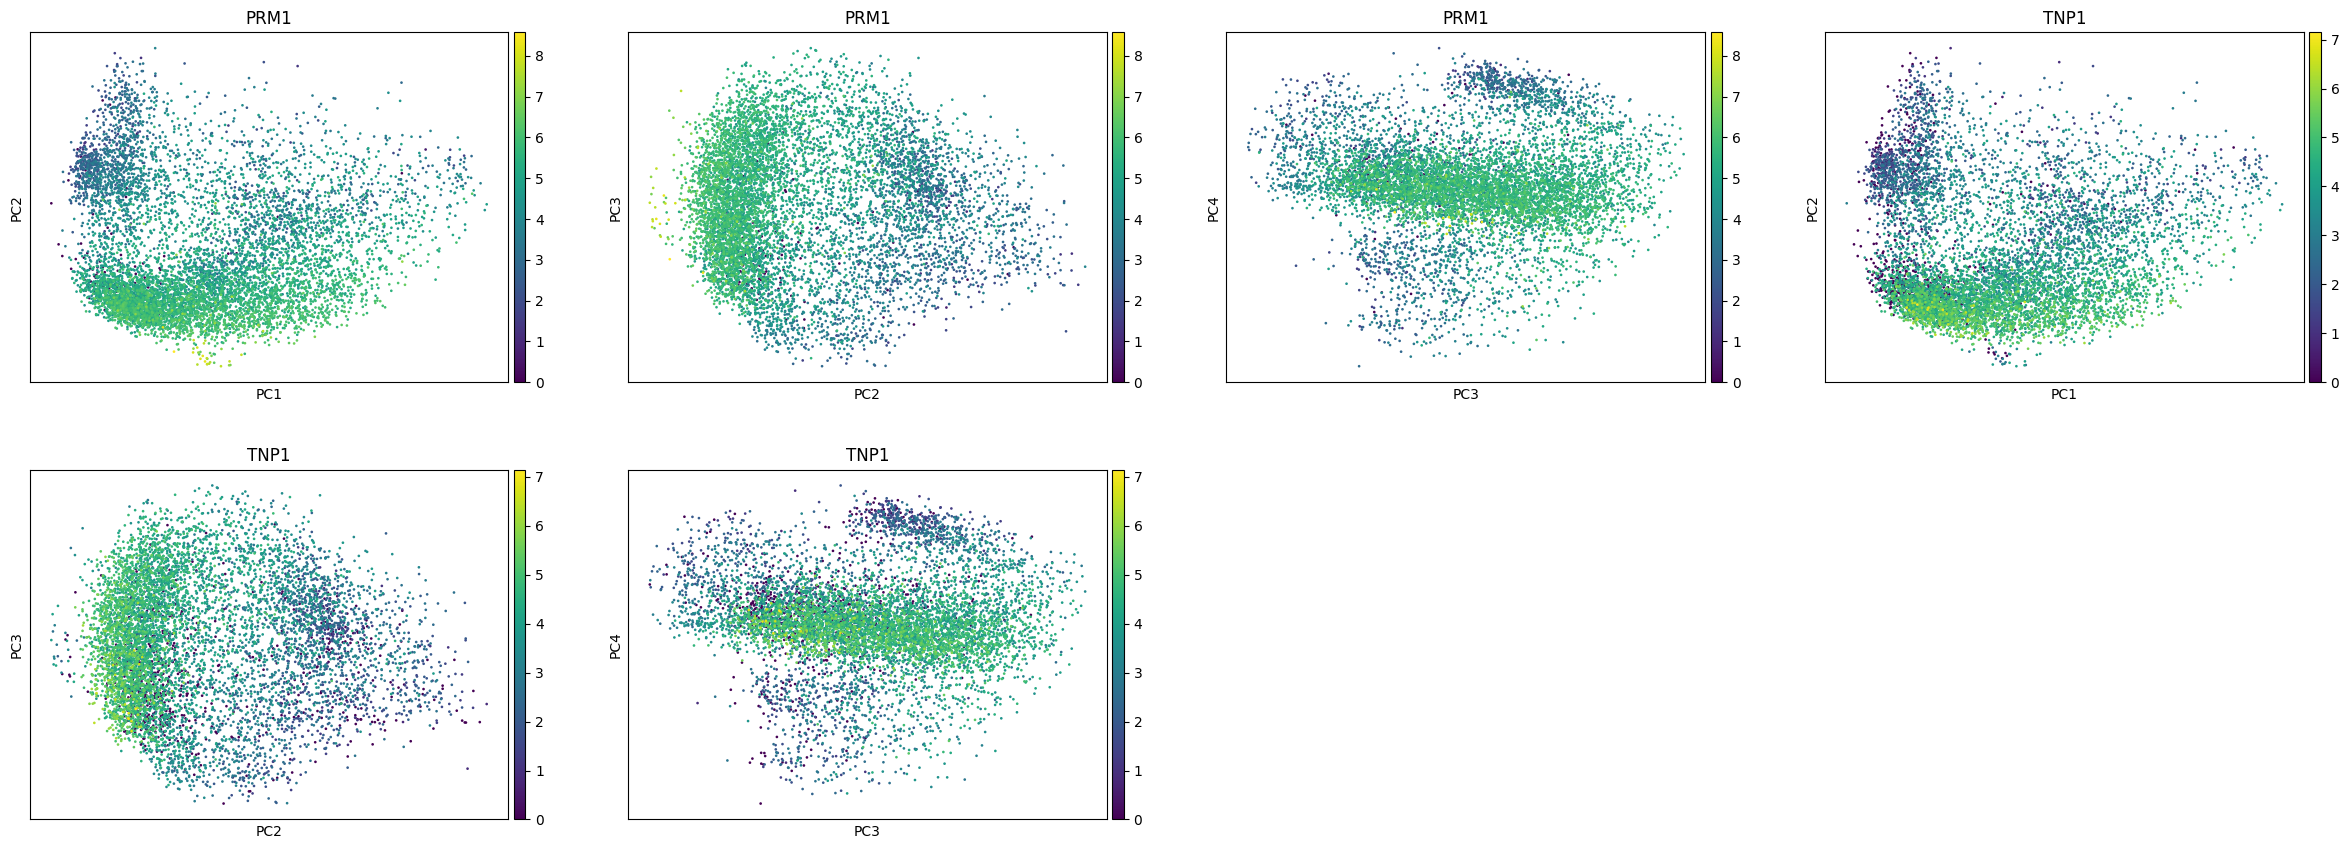

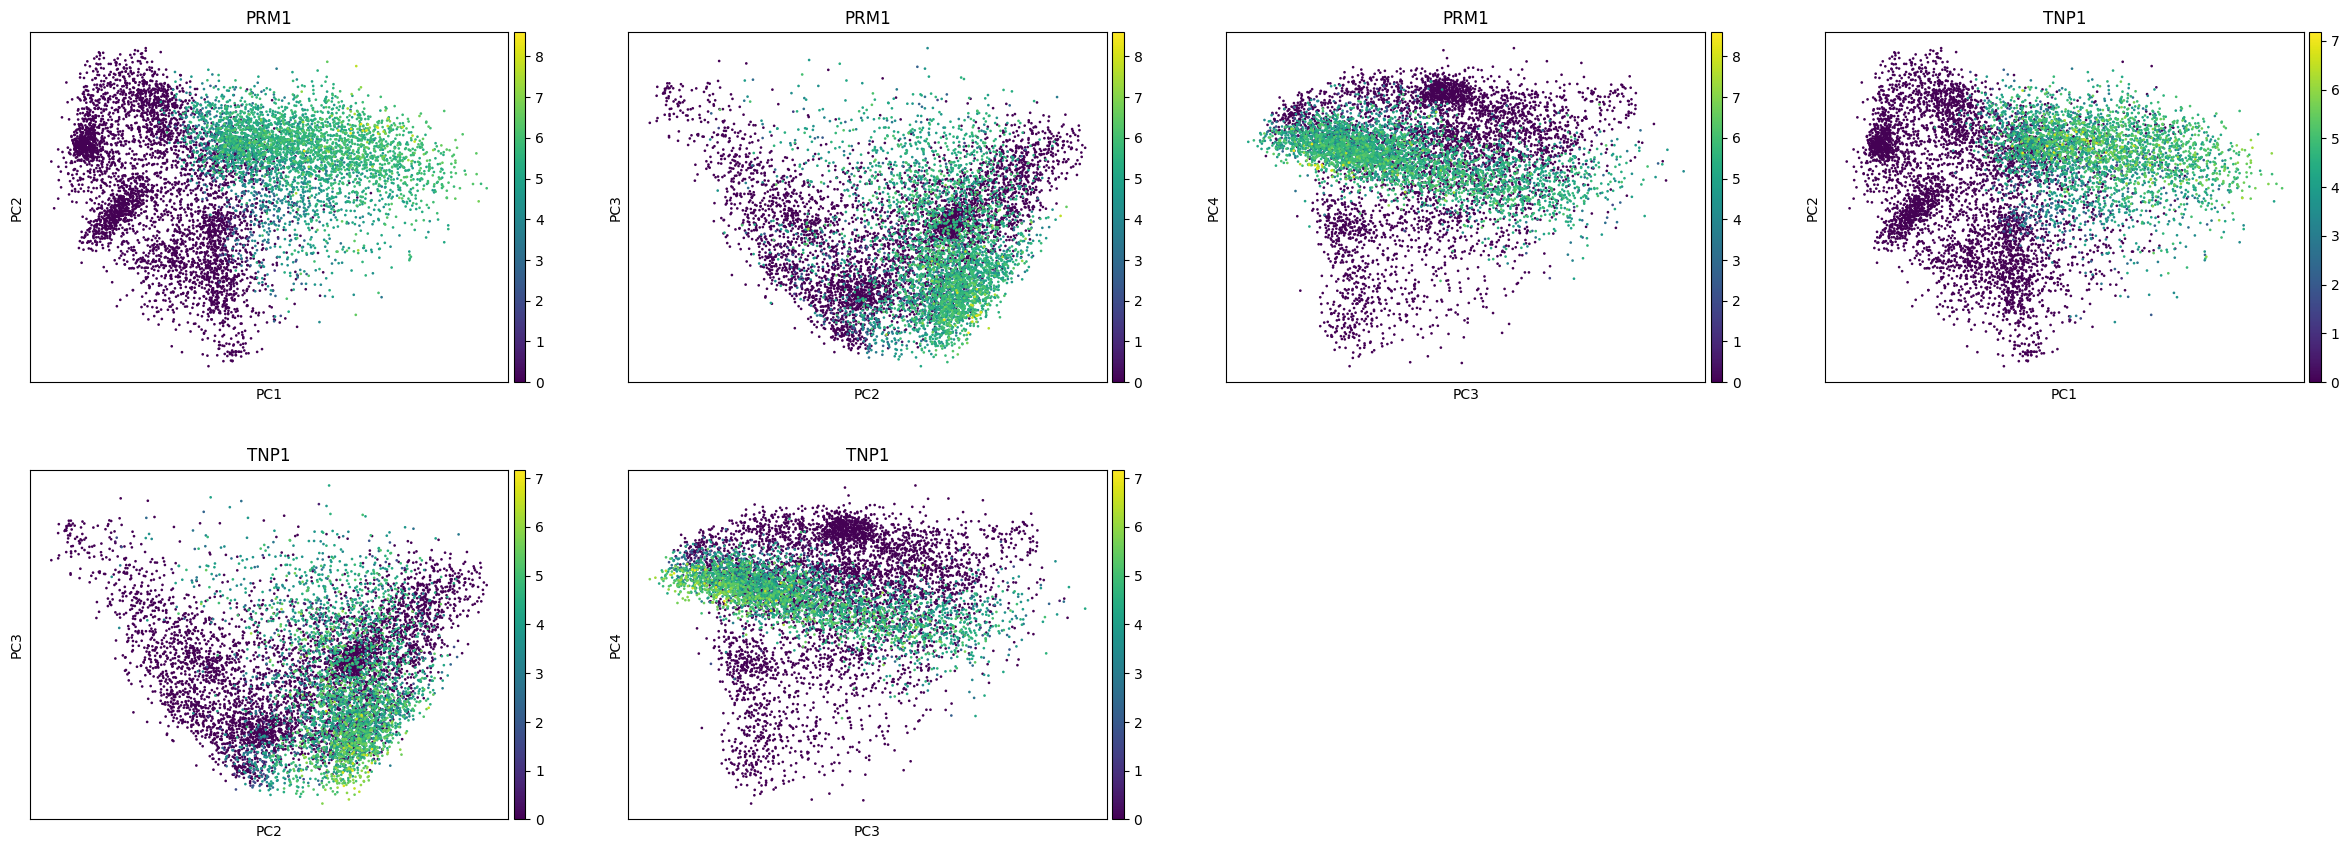

In [24]:
sc.pl.pca(crc, components = ['1,2', '2,3' , '3,4'], color=["PRM1", "TNP1"])
sc.pl.pca(pyEDc, components = ['1,2', '2,3' , '3,4'], color=["PRM1", "TNP1"])
sc.pl.pca(pyEDsoupc, components = ['1,2', '2,3' , '3,4'], color=["PRM1", "TNP1"])

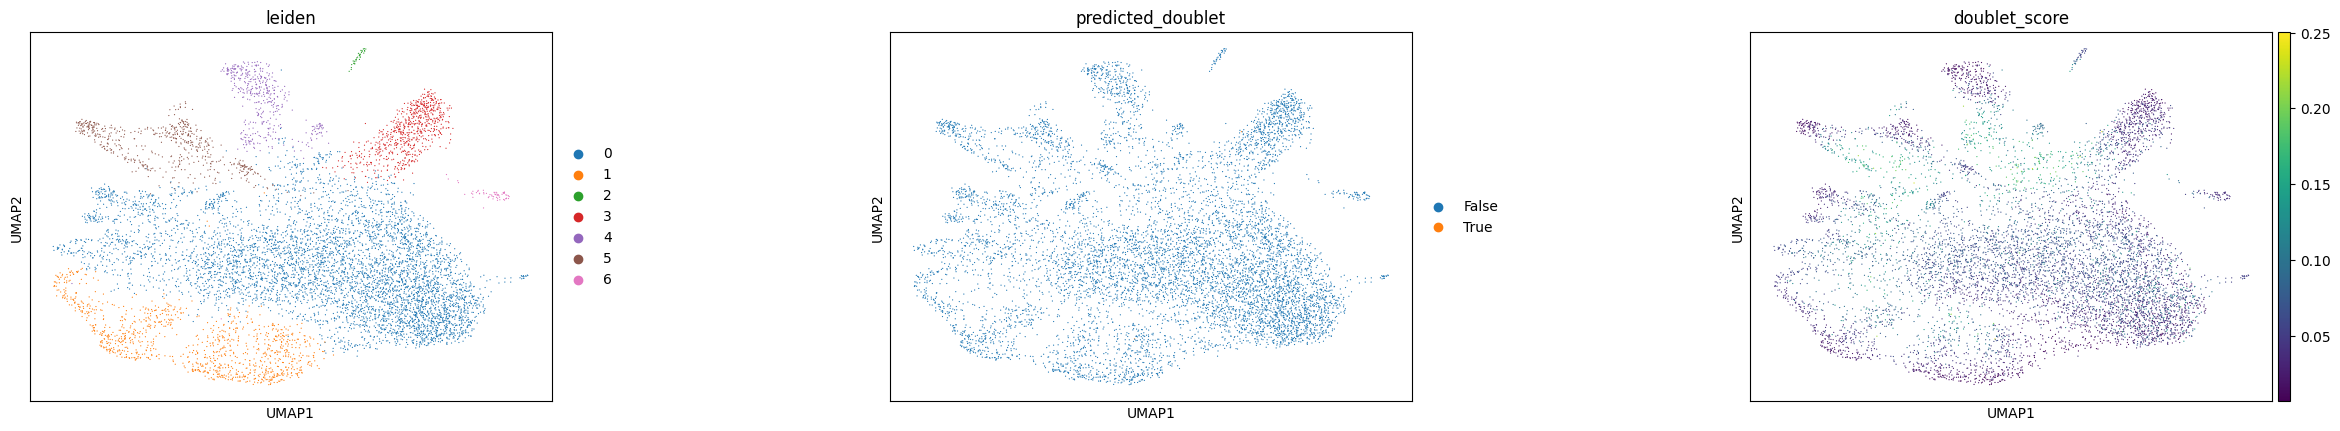

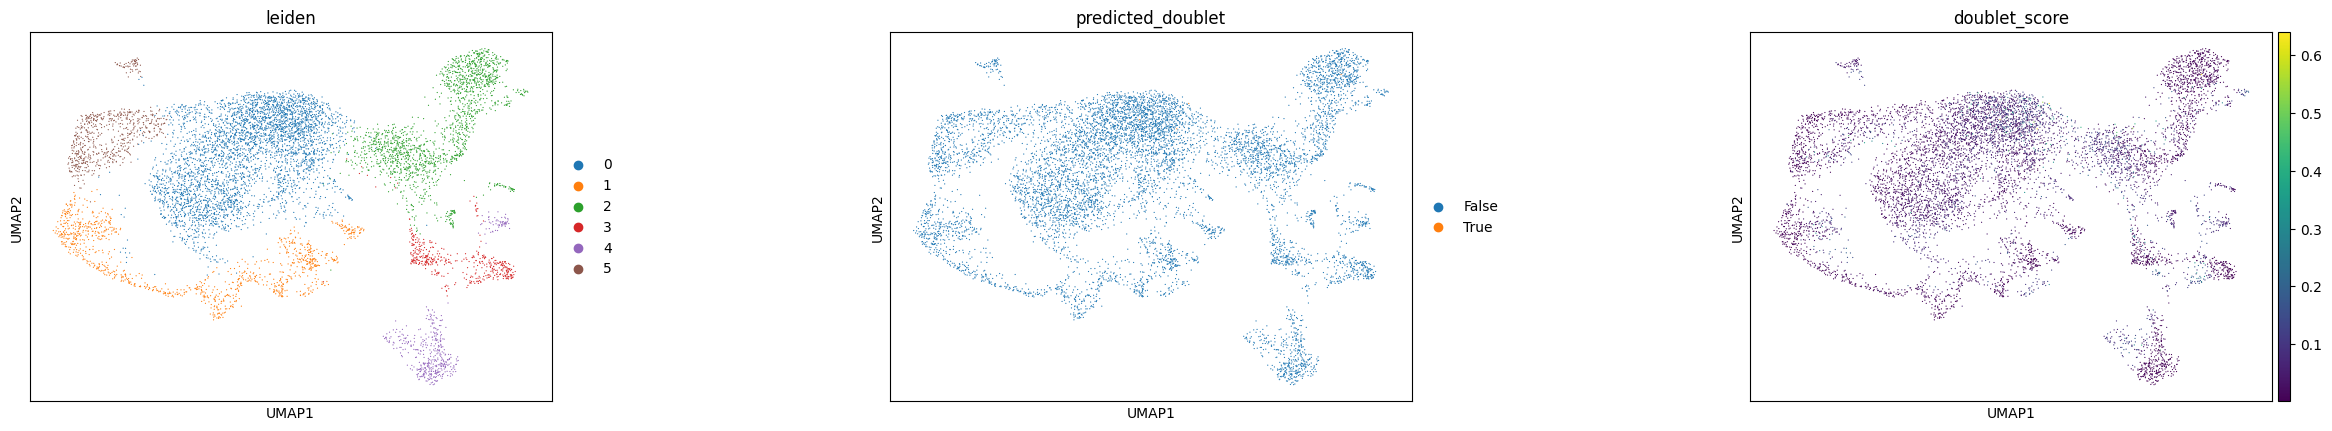

In [27]:
sc.pp.neighbors(pyEDc)
sc.tl.umap(pyEDc)
sc.tl.leiden(pyEDc, flavor="igraph", n_iterations=-1, resolution=0.1)
sc.pl.umap(pyEDc, color=["leiden", "predicted_doublet", "doublet_score"], wspace=0.5, size=3,)

sc.pp.neighbors(pyEDsoupc)
sc.tl.umap(pyEDsoupc)
sc.tl.leiden(pyEDsoupc, flavor="igraph", n_iterations=-1, resolution=0.1)
sc.pl.umap(pyEDsoupc, color=["leiden", "predicted_doublet", "doublet_score"], wspace=0.5, size=3,)

In [ ]:
sc.tl.rank_genes_groups(crc, groupby="leiden", method="wilcoxon", key_added="wilcox")
sc.tl.rank_genes_groups(pyEDc, groupby="leiden", method="wilcoxon", key_added="wilcox")
sc.tl.rank_genes_groups(pyEDsoupc, groupby="leiden", method="wilcoxon", key_added="wilcox")   

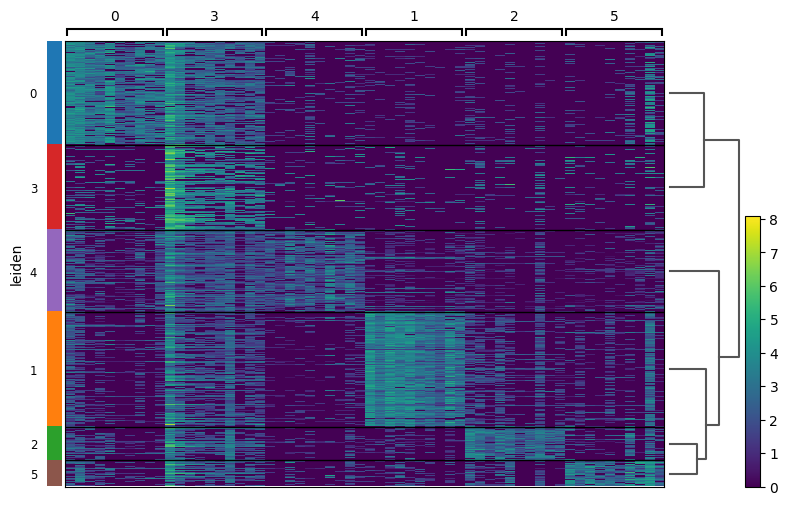

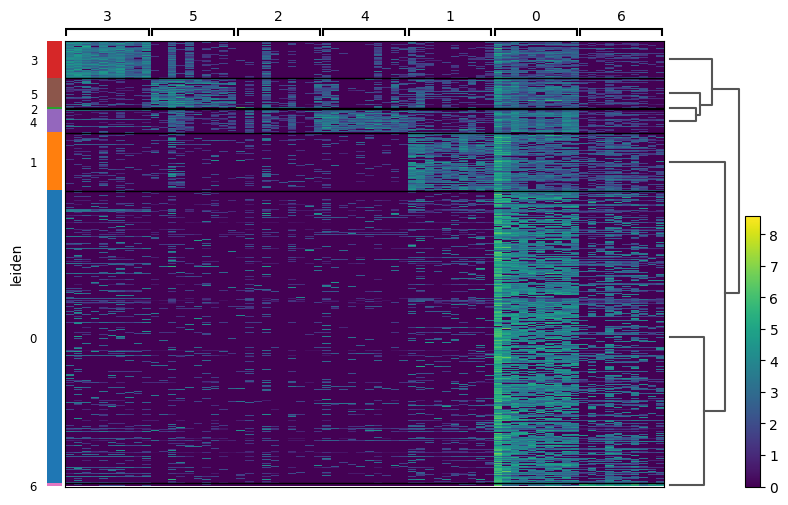

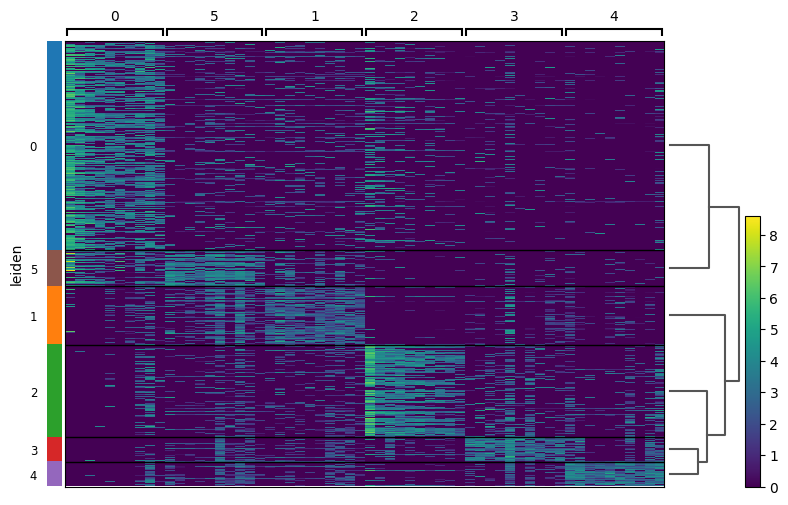

In [30]:
sc.pl.rank_genes_groups_heatmap(crc, groupby="leiden", key="wilcox")
sc.pl.rank_genes_groups_heatmap(pyEDc, groupby="leiden", key="wilcox")
sc.pl.rank_genes_groups_heatmap(pyEDsoupc, groupby="leiden", key="wilcox")

In [166]:
def simple_leiden(fg, hvg_bool):
    # avoid DE issues
    sc.pp.filter_genes(fg, min_counts=1)

    #  preprocessing pipeline 
    sc.pp.normalize_total(fg, target_sum=1e4)
    sc.pp.log1p(fg)
    if hvg_bool:
        sc.pp.highly_variable_genes(fg, n_top_genes=2000, flavor="seurat")
        fg = fg[:, fg.var["highly_variable"]].copy()
    #sc.pp.scale(fg, max_value=10)
    sc.tl.pca(fg, n_comps=30, svd_solver="arpack")
    sc.pp.neighbors(fg, n_neighbors=20, n_pcs=30)
    sc.tl.leiden(fg, resolution=0.5, flavor="igraph", n_iterations=2, directed=False, key_added="leiden_res0_5")
    sc.tl.leiden(fg, resolution=0.25, flavor="igraph", n_iterations=2, directed=False, key_added="leiden_res0_25")
    sc.tl.leiden(fg, resolution=1, flavor="igraph", n_iterations=2, directed=False, key_added="leiden_res1")

    sc.tl.umap(fg, min_dist=0.3, spread=1.0, random_state=42)
    sc.pl.umap(fg, color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"], legend_loc="on data", frameon=False, show=True)
    
    #sc.tl.rank_genes_groups(fg, "leiden", method="wilcoxon")

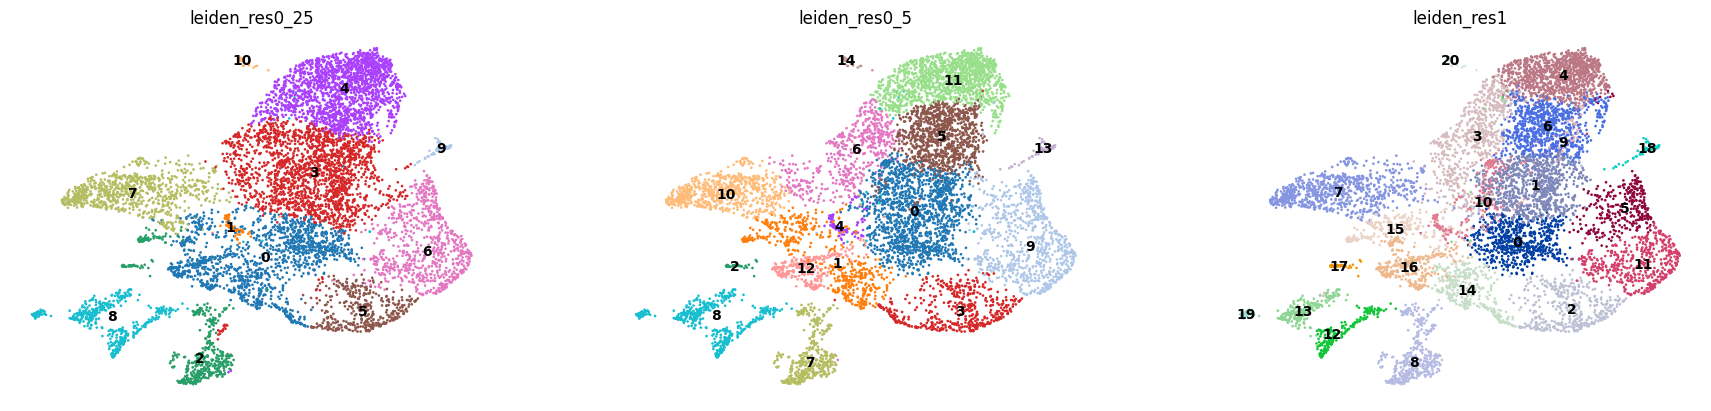

In [167]:
simple_leiden(pyED, False)

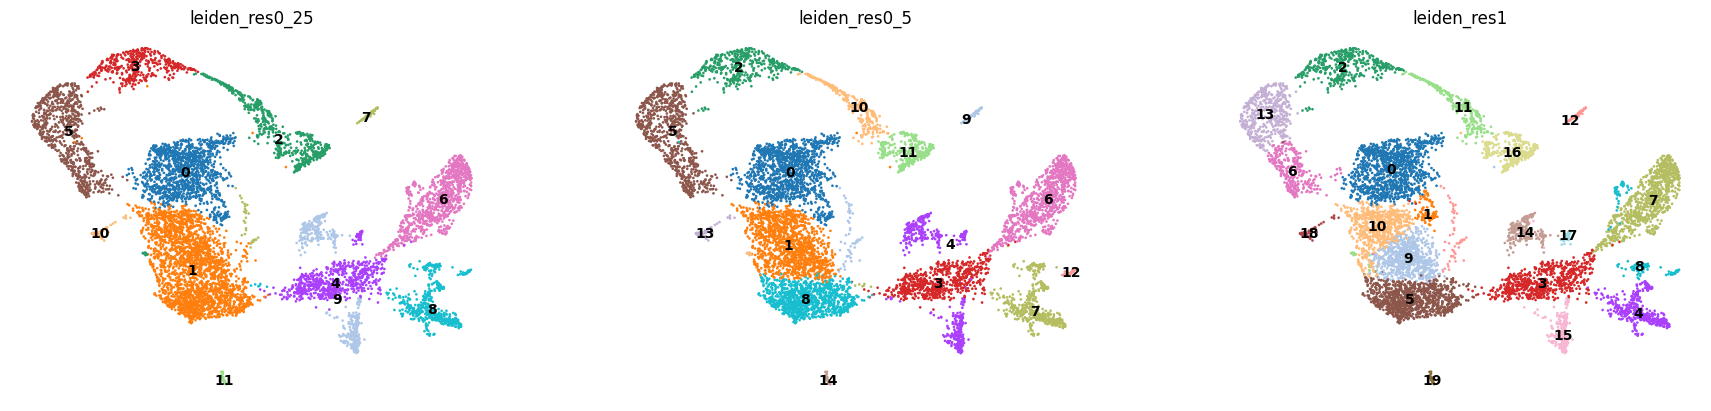

In [168]:
simple_leiden(pyEDsoup, False)

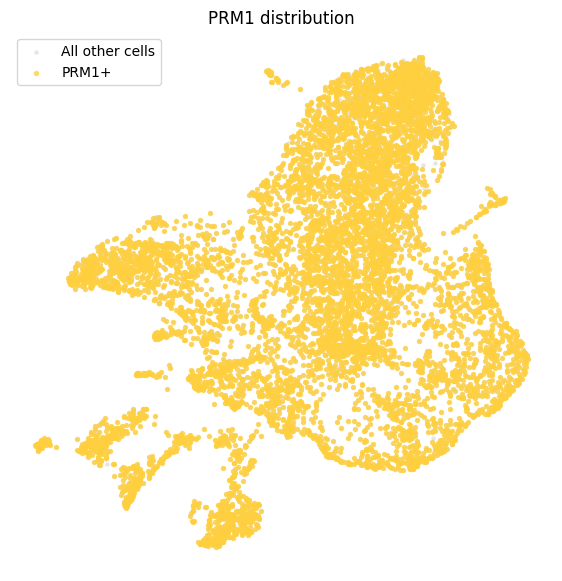

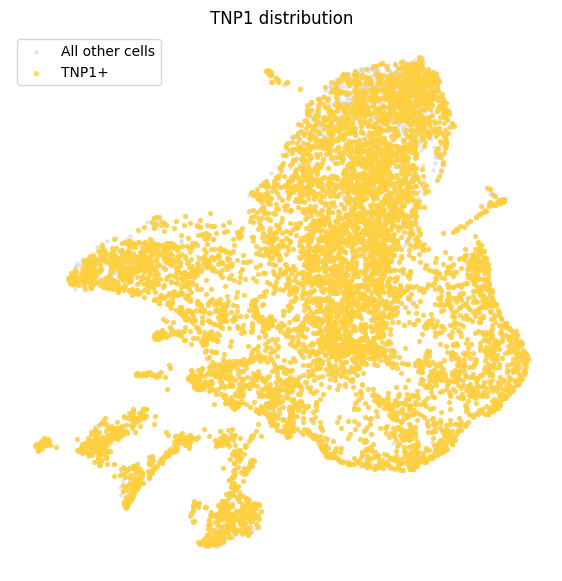

In [172]:

def plot_gene_on_leiden(fg, gene):
    # 3. Custom highlight plot for the user-supplied gene
    gene_to_highlight = gene
    if gene_to_highlight in fg.var_names:
        umap_coords = fg.obsm["X_umap"]
        y = fg[:, gene_to_highlight].X
        if not isinstance(y, np.ndarray):
            y = y.toarray().flatten()
        else:
            y = y.flatten()
        mask = y > 0
        fig, ax = plt.subplots(figsize=(7,7))
        ax.scatter(umap_coords[:,0], umap_coords[:,1], c="#cccccc", s=10, alpha=0.5, label="All other cells", linewidths=0)
        if mask.sum() > 0:
            ax.scatter(umap_coords[mask,0], umap_coords[mask,1], c="#FFCF3E", s=15, alpha=0.8, label=f"{gene_to_highlight}+", linewidths=0)
        ax.set_title(f"{gene_to_highlight} distribution")
        ax.axis("off")
        ax.legend(loc="best")
        plt.savefig(f"06_figures/{gene_to_highlight}_highlighted.png")
        plt.show()
    else:
        print(f"{gene_to_highlight} gene not found in the dataset.")

plot_gene_on_leiden(pyED, "PRM1")
#plot_gene_on_leiden(pyEDsoup, "PRM1")
plot_gene_on_leiden(pyED, "TNP1")
#plot_gene_on_leiden(pyEDsoup, "TNP1")


# pipeline 2

## load exclusive marker_genes (json)

In [243]:
import json
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
with open("02_mapped_gene_markers/exclusive_gene_markers.json", "r") as f:
    marker_genes = json.load(f)

adata = sc.read_h5ad("04_soup/pyED_correct_soupx.h5ad")

## subset to detected markers in our data

In [244]:
#sc.tl.pca(adata, n_comps=50)
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

sc.pp.filter_genes(adata, min_counts=1) #caused errors e.g. SOX3 wasnt able to be found afterwards in UMAP
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat")
#fg = fg[:, fg.var["highly_variable"]].copy()
#sc.pp.scale(adata, max_value=10) # do not use otherwise all log changes get NaN -> Run DE on a non-negative expression layer (raw counts or log1p-normalized), not on the scaled matrix.
sc.tl.pca(adata, n_comps=30, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
#sc.tl.leiden(adata, resolution=0.5, flavor="igraph", n_iterations=2, directed=False, key_added="leiden_res0_5")
sc.tl.umap(adata, min_dist=0.3, spread=1.0, random_state=42)

In [245]:
marker_genes_in_data = {}
for ct, markers in marker_genes.items():
    markers_found = []
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

print("Before: ", len(marker_genes.values()))
print("After: ", len(marker_genes_in_data.values()))

Before:  8
After:  8


In [246]:
B_plasma_cts = [
    "Early Sgonia",
    "Late Sgonia",
    "Early Scytes",
    "Late Scytes",
    "Round Stids",
    "Later Stids",
    "Sertoli",
    "Leydig"
]


## generate all cell type umaps

In [247]:
for ct in B_plasma_cts:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
        show = False,
        save = f"{ct.replace(' ', '')}.png",
    )
    print("\n\n\n")  # print white space for legibility

EARLY SGONIA:




LATE SGONIA:




EARLY SCYTES:




LATE SCYTES:




ROUND STIDS:




LATER STIDS:




SERTOLI:




LEYDIG:






## leiden

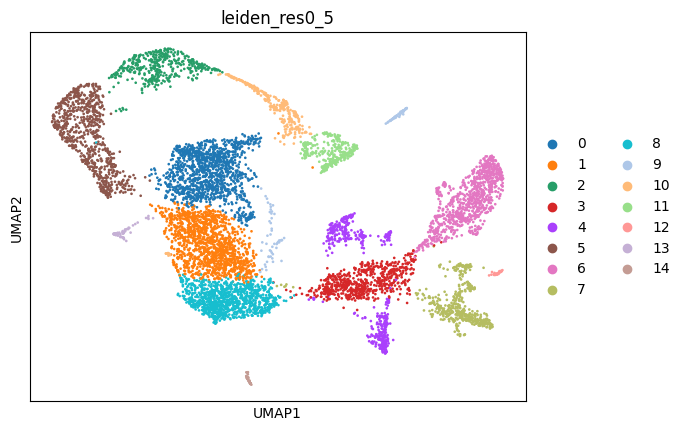

In [248]:
sc.tl.leiden(adata, resolution=0.5, flavor="igraph", n_iterations=2, directed=False, key_added="leiden_res0_5")
sc.pl.umap(adata, color="leiden_res0_5", save="leiden_res0_5.png")

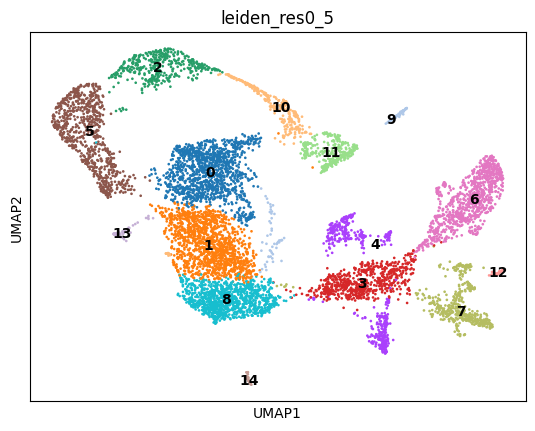

In [249]:
sc.pl.umap(adata, color="leiden_res0_5", legend_loc="on data", save="leiden_res0_5_ondata.png")

## dotplot cluster

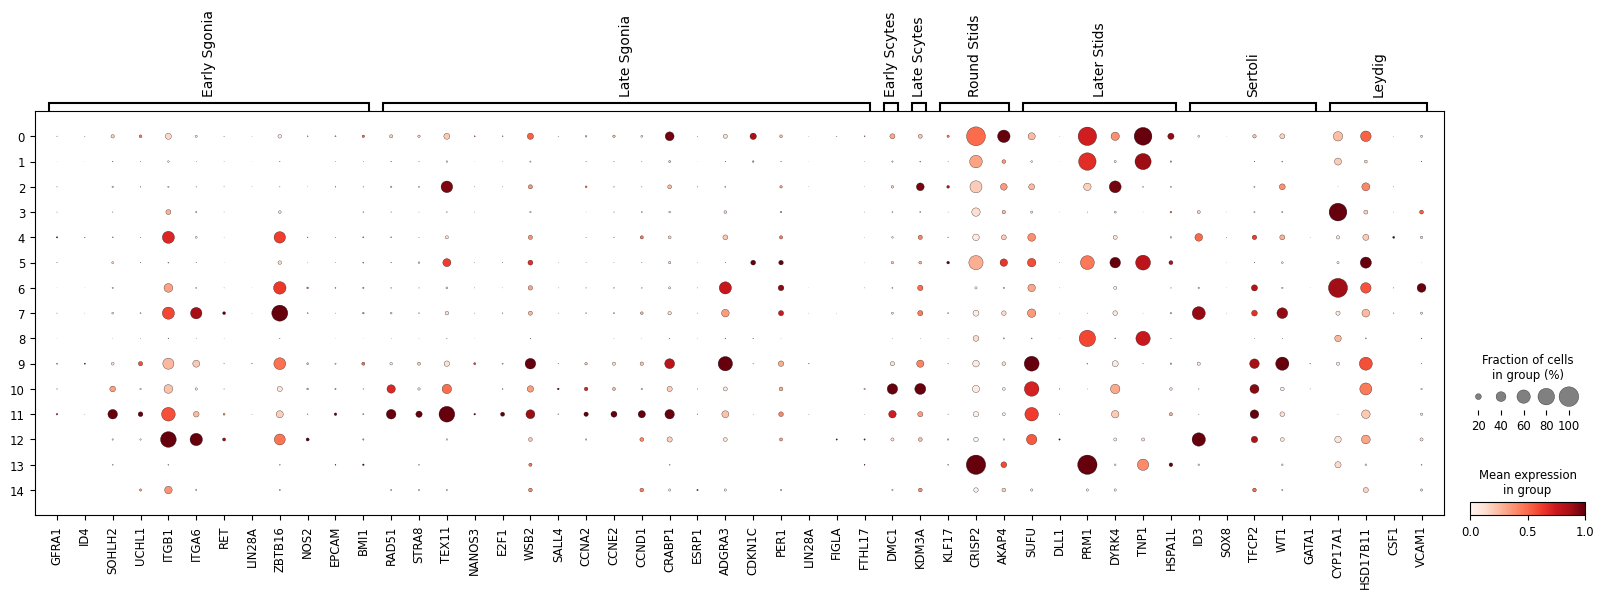

In [250]:
B_plasma_markers = {
    ct: [m for m in ct_markers if m in adata.var.index]
    for ct, ct_markers in marker_genes.items()
    if ct in B_plasma_cts
}

sc.pl.dotplot(
    adata,
    groupby="leiden_res0_5",
    var_names=B_plasma_markers,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    cmap = "Reds",
    save = "dotplot_leiden_res0_5.png",
)

## create annotated UMAP
with looking at the dotplot

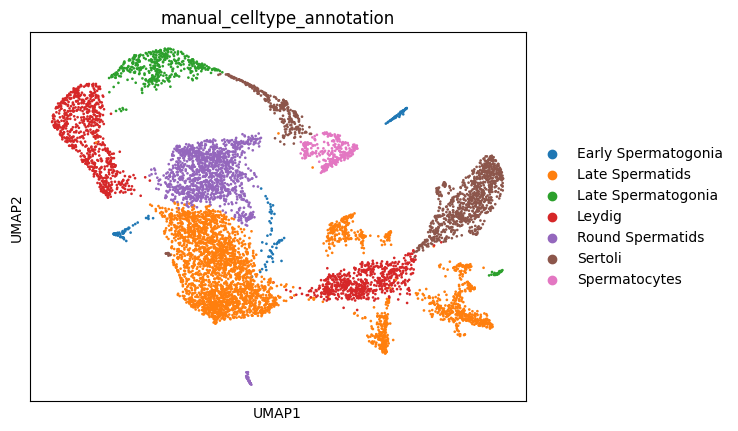

In [251]:
cl_annotation = {
    "0": "Round Spermatids", # auch bisschen Round
    "1": "Late Spermatids",
    "2": "Late Spermatogonia",
    "3": "Leydig",
    "4": "Late Spermatids",
    "5": "Leydig",
    "6": "Sertoli",
    "7": "Late Spermatids",
    "8": "Late Spermatids",
    "9": "Early Spermatogonia",
    "10": "Sertoli",
    "11": "Spermatocytes",
    "12": "Late Spermatogonia",
    "13": "Early Spermatogonia",
    "14": "Round Spermatids",
     # 15eher gar nichts
}

adata.obs["manual_celltype_annotation"] = adata.obs.leiden_res0_5.map(cl_annotation)
sc.pl.umap(adata, color=["manual_celltype_annotation"], save="oskar_self_annotated_umap.png")

## wilcoxon rank test

In [252]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden_res0_5", method="wilcoxon", key_added="dea_leiden_res0_5"
)

### dotplot wilcoxon

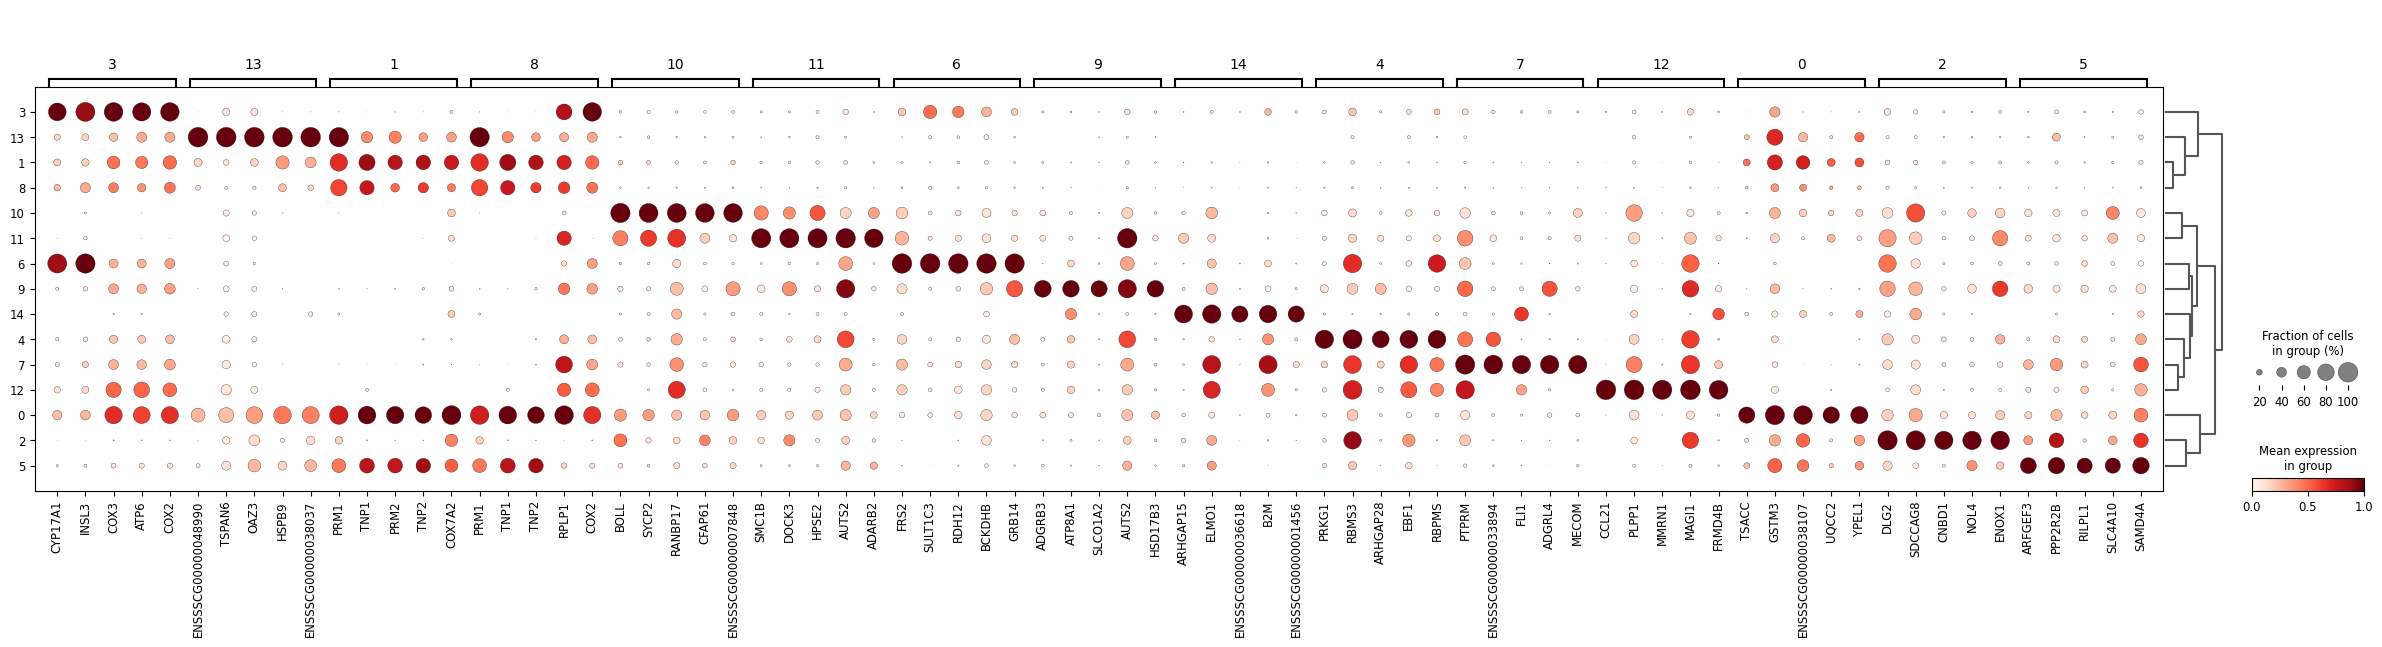

In [253]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_5", standard_scale="var", n_genes=5, key="dea_leiden_res0_5", save="wilcoxon_dotplot.png", cmap="Reds"
)


## HighlyExpressedGenes (HEG)

Filter out genes based on two criteria.

log fold change and

fraction of genes expressing the gene within and outside the groupby categories.

See rank_genes_groups().

Results are stored in adata.uns[key_added] (default: ‘rank_genes_groups_filtered’).

In [254]:
# check if ranks are in the key
sc.get.rank_genes_groups_df(adata, key="dea_leiden_res0_5", group="1").head()

names     scores  logfoldchanges          pvals      pvals_adj
0    PRM1  28.242596        3.717244  1.754920e-175  3.477199e-171
1    TNP1  24.890139        2.917549  9.514023e-137  9.425543e-133
2    PRM2  21.440800        2.338841  5.564887e-102   9.188556e-99
3    TNP2  20.564514        2.260064   5.706906e-94   6.651566e-91
4  COX7A2  20.519659        2.037582   1.437173e-93   1.498745e-90

logfoldchanges where all NaN due to scaling in the DE analysis in the first place. 
Run DE on a non-negative expression layer (raw counts or log1p-normalized), not on the scaled matrix.

In [255]:
sc.tl.filter_rank_genes_groups(
    adata,
    key="dea_leiden_res0_5",
    key_added="dea_leiden_res0_5_filtered",
    min_in_group_fraction=0.1,
    max_out_group_fraction=0.15,        
)

### dotplot HEG

categories: 0, 1, 2, etc.
var_group_labels: 0, 2, 3, etc.


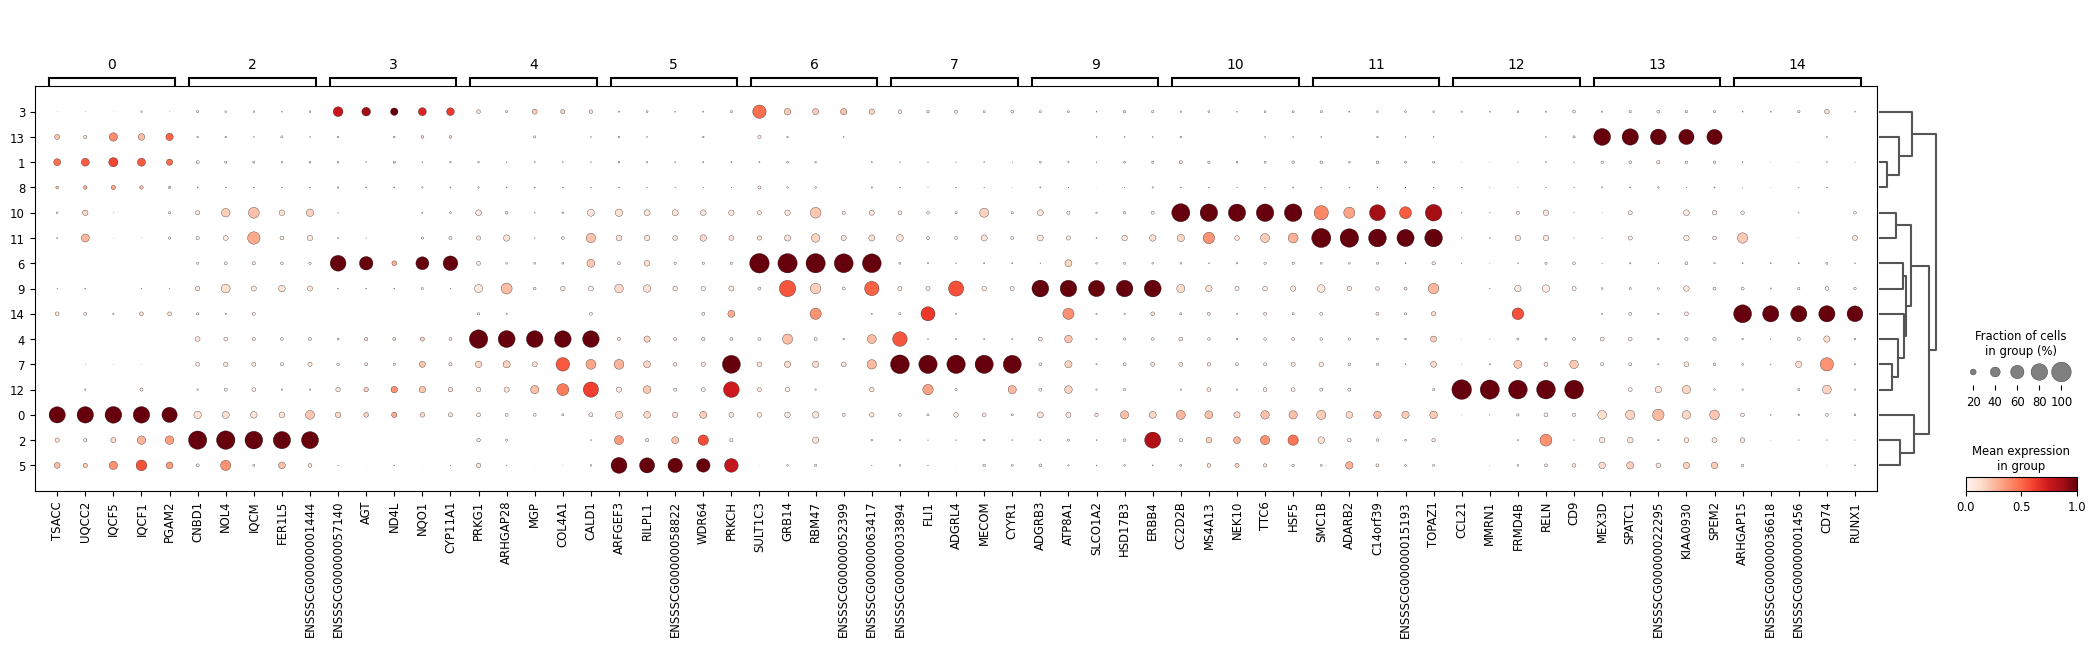

In [256]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_res0_5",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden_res0_5_filtered",
    save="HEG_dotplot.png",
    cmap="Reds"
)
